# 1.0 Case Study: constructing a network of wikipedia pages

## 1.1 Introduction

So far we have learned two ways of constructing a complex network:
- from a CSV file 
- manually

What is hard for small networks may be impossible for medium-to-large scale networks; it may be impossible even for small networks if you must repeat the analysis many
times. The case study in this lesson shows you **how to construct a large
network in an easy way**:  
- automatically collecting node and edge data from the Internet.

The other goal of this study (aside from mastering new network construction
techniques) is quite pragmatic. 
- Wouldn’t you want to know where the **complex
network analysis** fits in the context of other subjects and disciplines? 

An answer to this question is near at hand: [on Wikipedia](https://en.wikipedia.org/wiki/Complex_network).


To build a network out of the seed page and other relevant pages, **let’s treat
the pages (and the respective Wikipedia subjects) as the network nodes and
the links between the pages as the network edges**. You will use snowball
sampling (a breadth-first search or [BFS algorithm](https://en.wikipedia.org/wiki/Breadth-first_search)) to discover all the nodes and edges of interest.

<img width="200" src="https://drive.google.com/uc?export=view&id=1t9ZXB5Q-wRt_qWbf8eU_1RiTwVGaStHU">

As a result, you will have a network of all pages related
and hopefully, you will make some conclusions about it.

## 1.2 Get the Data, Build the Network

The first half of the project script consists of:

1. the initialization prologue
2. a heavy-duty loop that retrieves the Wikipedia pages and simultaneously builds the network of nodes and edges.

Let’s first import all necessary modules. We will need:

- the module **wikipedia** for fetching and exploring Wikipedia pages
- the operator **itemgetter** for sorting a list of tuples
- and, naturally, **networkx** itself.

To target the **snowballing process**, define the constant **SEED, the name of the
starting page**. 

> As a side note, by changing the name of the seed page, you can
apply this analysis to any other subject on Wikipedia.


Last but not least, when you start the snowballing, you will eventually (and
quite soon) bump into the pages describing ISBN and ISSN numbers, the
arXiv, PubMed, and the like. Almost all other Wikipedia pages refer to one or
more of those pages. This hyper-connectedness transforms any network into
a collection of almost perfect gigantic stars, making all Wikipedia-based networks
look similar. **To avoid the stardom syndrome**, treat the known “star”
pages as stop words in information retrieval—in other words, ignore any links
to them. 

Constructing the **black list of stop words**, STOPS, is a matter of trial
and error. We put thirteen subjects on it; you may want to add more when you
come across other “stars.” We also excluded pages whose names begin with
**"List of"**, because they are simply lists of other subjects.

In [1]:
# always check the current version in github
!pip install networkx==2.6.2

     |████████████████████████████████| 1.9 MB 3.9 MB/s 
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=543dd85e576dff5de721fe90ee376b83fa121f4e77b72f89c50474414a4de3b1
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia


In [3]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
from google.colab import files

In [4]:
nx.__version__

'2.6.2'

In [5]:
SEED = "2001: A Space Odyssey (novel)".title()
STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier", 
         "Pubmed Central",
         "Digital Object Identifier", 
         "Arxiv",
         "Proc Natl Acad Sci Usa", 
         "Bibcode",
         "Library Of Congress Control Number", 
         "Jstor",
         "Doi (Identifier)",
         "Isbn (Identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)",
         "Lcc (Identifier)",
         "Oclc (Identifier)",
         "Isni (Identifier)",
         "Rero (Identifier)",
         "Citerseerx (Identifier)",
         "Jstor (Identifier)",
         "Viaf (Identifier)",
         "S2Cid (Identifier)",
         "Issn (Identifier)",
         "Sudoc (Identifier)",
         "Mbrg (Identifier)",
         "Lccn (Identifier)",
         "Pmc (Identifier)",
         "Trove (Identifier)",
         "Asin (Identifier)",
         "Hdl (Identifier)")

The next code fragment deals with setting up the **snowballing process**. A
breadth-first search, or BFS (sometimes known to computer programmers
as a snowballing algorithm), must remember which **pages have been already
processed** and which have been **discovered but not yet processed**. 
- the former are stored in the set **done_set**; 
- the latter, in the list **todo_lst** and **todo_set**. 

You need two data structures for the unprocessed pages because you want to
know whether a page has been already recorded (an unordered lookup, *todo_set*) and
which page is the next to be processed (an ordered lookup, *todo_lst*). 


Snowballing an extensive network—and Wikipedia with 6,196,713 articles in
the English segment alone can produce a huge network!—takes considerable
time.

<img width="300" src="https://drive.google.com/uc?export=view&id=1cOpkuhQEHJ3UxQOP3hoCd3KzSlqyf1AG">

Suppose you start with one seed node, and let’s say it has $N\approx 100$ neighbors.
Each of them has $N$ neighbors, too, to the total of $\approx N+N×N$ nodes. The
third round of discovery adds $\approx N×N×N$ more nodes. The time to shave each
next layer of nodes grows exponentially. For this exercise, let’s process only
the seed node itself and its immediate neighbors (layers 0 and 1). Processing
layer 2 is still feasible, but layer 3 requires $N×N×N×N\approx 10^8$ page downloads. To keep track of the distance from the currently processed node to the seed, store both the layer to which a node belongs and the node name together as a tuple on the **todo_lst** list.

In [6]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0
todo_set = set(SEED) # The SEED itself
done_set = set() # Nothing is done yet

**The output of the exercise is a NetworkX graph**. The next fragment will create
an empty directed graph that will later absorb discovered nodes and edges.

> We choose a **directed graph** because the edges that represent HTML links
are naturally directed: a link from page A to page B does not imply a reciprocal
link. 

The same fragment primes the algorithm by extracting the first “to-do” item
(both its layer and page name) from the namesake list.



In [7]:
g = nx.DiGraph()
layer, page = todo_lst[0]

It may take a fraction of a second to execute the first five lines of the script.
It may take the whole next year or longer to finish the next twenty lines
because they contain the main collection/construction loop of the project.

In [8]:
%%time
while layer < 2:
  # Remove the name page of the current page from the todo_lst, 
  # and add it to the set of processed pages. 
  # If the script encounters this page again, it will skip over it.
  del todo_lst[0]
  done_set.add(page)
  
  # Show progress
  print(layer, page) 
  
  # Attempt to download the selected page.
  try:
    wiki = wikipedia.page(page)
  except:
    layer, page = todo_lst[0]
    print("Could not load", page)
    continue
  
  for link in wiki.links:
    link = link.title()
    if link not in STOPS and not link.startswith("List Of"):
      if link not in todo_set and link not in done_set:
        todo_lst.append((layer + 1, link))
        todo_set.add(link)
      g.add_edge(page, link)
  layer, page = todo_lst[0]

0 2001: A Space Odyssey (Novel)
1 2001: A Space Odyssey
1 2001: A Space Odyssey (Comics)
1 2001: A Space Odyssey (Film)
1 2001: A Space Odyssey (Score)
1 2001: A Space Odyssey (Soundtrack)
1 2001: A Space Odyssey In Popular Culture
1 2010: Odyssey Two
1 2010: The Year We Make Contact
1 2010 (Film)
1 2061: Odyssey Three
1 3001: The Final Odyssey
1 4923 Clarke
1 9000 Hal
1 A Fall Of Moondust
Could not load A Time Odyssey
1 A Time Odyssey
1 Advent (Publisher)
1 Against The Fall Of Night
1 Amazing Stories
1 An Encyclopedia Of Claims, Frauds, And Hoaxes Of The Occult And Supernatural
1 Arthur C. Clarke
Could not load Arthur C. Clarke'S Mysterious Universe
1 Arthur C. Clarke'S Mysterious Universe
1 Arthur C. Clarke'S Mysterious World
1 Arthur C. Clarke'S World Of Strange Powers
1 Arthur C. Clarke Award
1 Arthur C. Clarke Institute For Modern Technologies
1 Arthur C. Clarke Bibliography
1 Arthur C. Clarke In Media
1 Artificial Intelligence
1 Australopithecus Africanus
1 Before Present
1 Broad

/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Could not load Gentry Lee
1 Gentry Lee
1 Geostationary Orbit
1 Glide Path
1 God, The Universe And Everything Else
1 Great Basses Wreck
1 Hal 9000
Could not load Heywood Floyd
1 Heywood Floyd
1 Hominid
1 How The World Was One
1 Hutchinson (Publisher)
1 Iapetus (Moon)
1 Immortality
Could not load Imperial Earth
1 Imperial Earth
1 Internet Speculative Fiction Database
1 Interplanetary Flight: An Introduction To Astronautics
1 Interpretations Of 2001: A Space Odyssey
1 Islands In The Sky
1 James Blish
Could not load Jupiter
1 Jupiter
1 Latin Language
1 Latin Spelling And Pronunciation
1 Leopard
1 Machine Man
1 Mcfarland & Company
1 Michael P. Kube-Mcdowell
1 Mike Mcquay
1 Mission Control Center
1 Monolith (Space Odyssey)
1 More Than One Universe
1 New American Library
1 Of Time And Stars
1 Orbital Mechanics
1 Poole Versus Hal 9000
1 Prelude To Space
1 Project Barsoom
1 Rama (Video Game)
Could not load Rama Ii (Novel)
1 Rama Ii (Novel)
1 Rama Revealed
1 Reach For Tomorrow
1 Rendezvous With 

In [9]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

17669 nodes, 32398 edges


The network of interest is now in the variable g. But it is “dirty”: inaccurate, incomplete, and erroneous.

## 1.3 Eliminate Duplicates

Many Wikipedia pages exist under two or more names. For example, there
are pages about **Complex Network** and **Complex Networks**. The latter redirects
to the former, but NetworkX does not know about the redirection.

Accurately merging all duplicate nodes involves **natural language processing
(NLP) tools that are outside of the scope of this course**. It may suffice to join
only those nodes that differ by the presence/absence of the letter s at the end
or a hyphen in the middle.

Start removing self-loops (pages referring to themselves). The loops don’t change
the network properties but affect the correctness of duplicate node elimination.
Now, you need a list of at least some duplicate nodes. You can build it by
looking at each node in g and checking if a node with the same name, but
with an s at the end, is also in g. 

Pass each pair of duplicated node names to the function **nx.contracted_nodes(g,u,v)** that merges node v into node u in the graph g. The function reassigns all edges previously incident to v, to u. If you don’t pass the option **self_loops=False**, the function converts an edge from v to u (if any) to a self-loop.

In [10]:
# make a copy of raw graph
original = g.copy()

In [11]:
# remove self loops
g.remove_edges_from(nx.selfloop_edges(g))

# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s") 
              for node in g if node + "s" in g
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(g, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in 
              [(node, node.replace("-", " ")) for node in g]
                if x != y and y in g]
print(duplicates)

for dup in duplicates:
  g = nx.contracted_nodes(g, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(g, 0,"contraction")
nx.set_edge_attributes(g, 0,"contraction")

[('Film Score', 'Film Scores'), ('Retcon', 'Retcons'), ('Comet', 'Comets'), ('Detached Object', 'Detached Objects'), ('Near-Earth Object', 'Near-Earth Objects'), ('Computer', 'Computers'), ('Pulp Magazine', 'Pulp Magazines'), ('Science Fiction Convention', 'Science Fiction Conventions'), ('Academy Award', 'Academy Awards'), ('Academic Journal', 'Academic Journals'), ('Deepfake', 'Deepfakes'), ('Evolutionary Algorithm', 'Evolutionary Algorithms'), ('Expert System', 'Expert Systems'), ('Genetic Algorithm', 'Genetic Algorithms'), ('Heuristic', 'Heuristics'), ('Idea', 'Ideas'), ('Intelligent Agent', 'Intelligent Agents'), ('Recommendation System', 'Recommendation Systems'), ('Recurrent Neural Network', 'Recurrent Neural Networks'), ('Robot', 'Robots'), ('Robotic', 'Robotics'), ('Self-Driving Car', 'Self-Driving Cars'), ('Archaic Human', 'Archaic Humans'), ('Australopithecine', 'Australopithecines'), ('Hominin', 'Hominins'), ('Orangutan', 'Orangutans'), ('Archaeologist', 'Archaeologists'), 

In [12]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

17596 nodes, 32338 edges


## 1.4 Truncate the network

Why did you go through all those Wikipedia troubles? First, to construct a
network of subjects related to complex networks—and here it is. Second, to
find other significant topics related to complex networks. **But what is the
measure of significance?**


You will discover a variety of network measures latter in this course. For now, let’s concentrate on a **node indegree**—the number of edges directed into the node. (In the same spirit, the number of edges directed out of the node is called **outdegree**.) The indegree of a node equals the number of HTML links pointing to the respective page. **If a page has a lot of links to it, the topic of the page must be significant.**


The choice of indegree as a yardstick of significance incidentally makes it
possible to shrink the graph size by almost 75 percent. The extracted graph
has 13,401 nodes and 24104 edges—an average of 1.79 edges per node. **Most
of the nodes have only one connection**. (Interestingly, there are no isolated
nodes with no connection in the graph. Even if they exist, you will not find
them because of the way snowballing works.) **You can remove all nodes with
only one incident edge to make the network more compact and less hairy
without hurting the final results**.

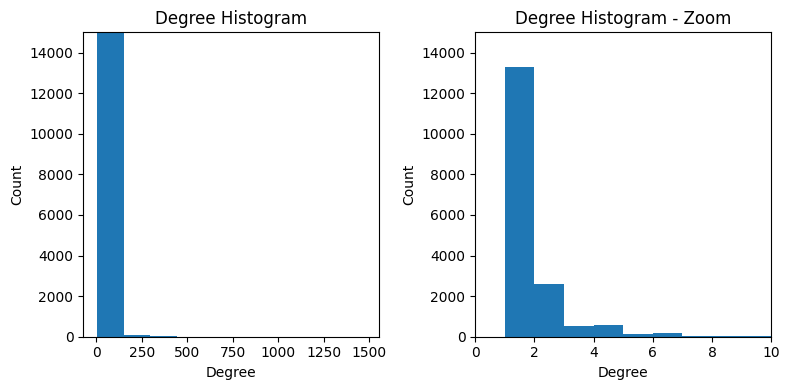

In [13]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

fig, ax = plt.subplots(1,2,figsize=(8,4))

# all_data has information about degree_sequence and the width of each bin
ax[0].hist(degree_sequence)
ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")
ax[0].set_ylim(0,15000)

ax[1].set_title("Degree Histogram - Zoom")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Degree")
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,15000)

plt.tight_layout()
plt.show()

In [14]:
# filter nodes with degree greater than or equal to 2
core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

# select a subgraph with 'core' nodes
gsub = nx.subgraph(g, core)

print("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

nx.write_graphml(gsub, "cna.graphml")

4318 nodes, 19060 edges


In [15]:
files.download("cna.graphml")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

As you can see, the following code fragment safely removes 77 percent of the
nodes and 42 percent of the edges, raising the average number of edges per
node to 4.35.

## 1.5 Explore the network

The following figure is a [Gephi](https://gephi.org/) rendering of **gsub**. Node
and label font sizes represent the indegrees (a filter was added in gephi just to show only node with indegree greater than 50). The most in-connected, most significant
nodes are in the upper-left corner of the network. What are they?

<img width="600" src="https://drive.google.com/uc?export=view&id=1Cemnpe6yBttyZ8Vw2i9ifMiWx9psIV7C">


The last code fragment of the exercise efficiently calculates the answer by
calling the method **gsub.in_degree()**. The method (and its sister method **gsub.out_degree()**)
are very similar to **gsub.degree()** except that they report different edge counts in the form of objects InDegreeView and OutDegreeView, respectively.

In [16]:
top_indegree = sorted(dict(gsub.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:100]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))

101 Arthur C. Clarke
94 2001: A Space Odyssey (Film)
90 2001: A Space Odyssey (Novel)
88 2010: The Year We Make Contact
88 A Time Odyssey
87 2010: Odyssey Two
87 3001: The Final Odyssey
87 2001: A Space Odyssey (Comics)
87 The Lost Worlds Of 2001
87 2061: Odyssey Three
84 Space Odyssey
73 Rendezvous With Rama
73 Science Fiction
72 Geostationary Orbit
72 Stephen Baxter (Author)
71 Frederik Pohl
71 Cradle (Novel)
71 Michael P. Kube-Mcdowell
71 Childhood'S End
71 The Trigger
71 The Last Theorem
70 Rama (Video Game)
70 The Light Of Other Days
70 The Garden Of Rama
70 Sunstorm (Novel)
70 Glide Path
70 Rama Ii (Novel)
70 A Fall Of Moondust
70 Grb 080319B
70 Mike Mcquay
70 Arthur C. Clarke Institute For Modern Technologies
70 Time'S Eye (Novel)
70 Richter 10
70 The Nine Billion Names Of God (Collection)
70 Expedition To Earth
70 Serendipaceratops
70 Gentry Lee
70 Arthur C. Clarke Award
70 Firstborn (Clarke And Baxter Novel)
70 Rama Revealed
69 The Sands Of Mars
69 The Fountains Of Paradise
69

**Exercise**

<img width="100" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


- This section presented a complete complex network construction case study,
starting from the raw data in the form of HTML pages, all the way to an analyzable
annotated network graph and a simple exploratory exercise. This is
a good foundation for more systematic complex network studies. Now is your turn, choice a topic of your interest and reproduce yourself a complet complex network case study. 

- Some examples (not limited to):

  - https://en.wikipedia.org/wiki/Black_Lives_Matter
  - https://en.wikipedia.org/wiki/COVID-19
  - https://en.wikipedia.org/wiki/Harry_Potter
  - https://en.wikipedia.org/wiki/Sherlock_Holmes
  - https://en.wikipedia.org/wiki/Augusto_Severo_de_Albuquerque_Maranh%C3%A3o
  - https://en.wikipedia.org/wiki/Brazil
  - https://en.wikipedia.org/wiki/Bitcoin
  - https://en.wikipedia.org/wiki/Federal_University_of_Rio_Grande_do_Norte
  - https://en.wikipedia.org/wiki/Petrobras
  - https://en.wikipedia.org/wiki/List_of_presidents_of_Brazil
- Explore some metrics studied in Unit 01 to highlight insights in your analysis.

In [17]:
# put your results here